In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import time
import random
from itertools import combinations
from tqdm.notebook import tqdm
import optuna
import math

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.feature_selection import RFECV, mutual_info_classif

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from concurrent.futures import ThreadPoolExecutor
from category_encoders import TargetEncoder

from lightgbm import LGBMClassifier

from pprint import pprint
import os

pd.set_option('display.max_columns', None)

experiment_name = 'lgbm'

In [2]:
train = pd.read_csv(r'.\train.csv')
test = pd.read_csv(r'.\test.csv')

train.head(2)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0


In [3]:
train.tail(2)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.0,1,0.0,1.0,71173.03,0
165033,165033,15732798,Ulyanov,850,France,Male,31.0,1,0.0,1,1.0,0.0,61581.79,1


In [4]:
# Columns with missing values
train.columns[train.isna().any()]

Index([], dtype='object')

In [5]:
TARGET = 'Exited'
binary_cols = ['Gender', 'HasCrCard', 'IsActiveMember']
categorical_cols = ['Geography', 'NumOfProducts']
text_cols = ['Surname']
drop_cols = ['id']

In [6]:
numerical_cols = train.drop(categorical_cols + binary_cols + drop_cols + [TARGET], axis=1).select_dtypes(include=np.number).columns
numerical_cols

Index(['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'EstimatedSalary'],
      dtype='object')

# Preprocess Data

In [7]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='infrequent_if_exist', drop='if_binary'), binary_cols),
    (OneHotEncoder(sparse=False, handle_unknown='infrequent_if_exist'), categorical_cols),
    (TargetEncoder(), text_cols),
    (StandardScaler(), numerical_cols),
    remainder='passthrough')

df_to_ohe = train.drop(drop_cols, axis=1)
test_ohe = test.drop('id', axis=1)

# transformed = transformer.fit_transform(df_to_ohe)

# Split the features and the target variable
X = df_to_ohe.drop(TARGET, axis=1)
y = df_to_ohe[TARGET]

# Fit the transformer
transformer.fit(X, y)

transformed = transformer.transform(X)

# Get the transformed feature names
transformed_feat_names = [name.split('__')[-1] for name in transformer.get_feature_names_out()]

# Create DataFrame of the transformed features
df_to_ohe_transformed = pd.DataFrame(transformed, columns=transformed_feat_names)
df_to_ohe_transformed.sample()

,Gender_Male,HasCrCard_1.0,IsActiveMember_1.0,Geography_France,Geography_Germany,Geography_Spain,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Surname,CustomerId,CreditScore,Age,Tenure,Balance,EstimatedSalary
9014,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.201493,1.158848,-0.904514,-0.916401,-0.719973,0.97401,0.620353


In [8]:
transformed_new_data = transformer.transform(test_ohe)

# Create DataFrame of the transformed features
test_transformed = pd.DataFrame(transformed_new_data, columns=transformed_feat_names)
test_transformed.sample()

,Gender_Male,HasCrCard_1.0,IsActiveMember_1.0,Geography_France,Geography_Germany,Geography_Spain,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Surname,CustomerId,CreditScore,Age,Tenure,Balance,EstimatedSalary
3301,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.168146,-1.244734,-0.005672,0.211354,-1.432694,1.789318,0.781671


In [9]:
encoded_binary_cols = []
encoded_categorical_cols = []

# Loop through every column columns to separate binary and categorical
for col in df_to_ohe_transformed.columns:
    unique_values = df_to_ohe_transformed[col].nunique(dropna=False)
    print(f'{col} has {unique_values} unique values')
    if unique_values == 2:
        encoded_binary_cols.append(col)
    elif unique_values > 2 and unique_values < 10:
        encoded_categorical_cols.append(col)

encoded_numerical_cols = list(df_to_ohe_transformed.drop(encoded_binary_cols, axis=1).select_dtypes(include=np.number).columns)
len(encoded_numerical_cols), len(encoded_binary_cols), len(encoded_categorical_cols)

Gender_Male has 2 unique values
HasCrCard_1.0 has 2 unique values
IsActiveMember_1.0 has 2 unique values
Geography_France has 2 unique values
Geography_Germany has 2 unique values
Geography_Spain has 2 unique values
NumOfProducts_1 has 2 unique values
NumOfProducts_2 has 2 unique values
NumOfProducts_3 has 2 unique values
NumOfProducts_4 has 2 unique values
Surname has 858 unique values
CustomerId has 23221 unique values
CreditScore has 457 unique values
Age has 71 unique values
Tenure has 11 unique values
Balance has 30075 unique values
EstimatedSalary has 55298 unique values


(7, 10, 0)

In [10]:
# Reset indexes before assignment to reassign indices to both DataFrames, ensuring they are aligned
df_to_ohe_transformed.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)
df_to_ohe_transformed[TARGET] = train[TARGET]

df_to_ohe_transformed.head()

,Gender_Male,HasCrCard_1.0,IsActiveMember_1.0,Geography_France,Geography_Germany,Geography_Spain,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Surname,CustomerId,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.318008,-0.239126,0.144135,-0.578074,-0.719973,-0.883163,1.369486,0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.326667,0.800755,-0.367706,-0.578074,-1.432694,-0.883163,-1.254085,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.222052,0.035085,0.268974,0.211354,1.774548,-0.883163,1.437422,0
3,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.181991,0.692068,-0.941966,-0.465299,-1.076334,1.486918,-0.557018,0
4,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.146341,1.038788,0.743362,-0.578074,-0.007253,-0.883163,-1.938770,0


In [11]:
# Check for rows with misaligned indices
print(df_to_ohe_transformed.index.equals(train.index))

True


In [12]:
# Print out the rows with misaligned indices
condition_1 = df_to_ohe_transformed[TARGET] != 1
condition_2 = df_to_ohe_transformed[TARGET] != 0
df_to_ohe_transformed[(condition_1) & (condition_2)]

,Gender_Male,HasCrCard_1.0,IsActiveMember_1.0,Geography_France,Geography_Germany,Geography_Spain,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Surname,CustomerId,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited


# Feature Selection

- Mutual Information

In [13]:
# # Generate a random feature
# np.random.seed(5)
# df_to_ohe_transformed['random_control_feature'] = np.round(np.random.uniform(-2, 2, df_to_ohe_transformed.shape[0]), 6)
# df_to_ohe_transformed.shape

In [14]:
# # Calculate mutual information - this can be memory and CPU intensive
# # The plan is to remove any features that have mutual information less than random_feature because surely you cannot be important
# mi_scores = mutual_info_classif(df_to_ohe_transformed, df_to_ohe_transformed[TARGET], discrete_features='auto', n_neighbors=20, copy=True, random_state=5)

# # Make results easier to interpret by placing them in a DataFrame
# mi_scores = pd.Series(mi_scores, name="MI Scores", index=df_to_ohe_transformed.columns)
# mi_scores = mi_scores.sort_values(ascending=False)

# # Now you have the MI scores sorted from the most to the least informative
# mi_scores.to_csv(f'{experiment_name}_20_mi_scores.csv')

In [15]:
# Read the CSV
mi_df = pd.read_csv('lgbm_mi_scores.csv')

# Get the mi score for control feature
mi_threshold = mi_df.loc[mi_df['Feature'] == 'random_control_feature', 'Average'].iloc[0]

# Get the features above random_control_feature to move forward
mi_feats = mi_df[mi_df['Average'] > mi_threshold]['Feature'].tolist()
mi_feats

['Age',
 'NumOfProducts_2',
 'NumOfProducts_1',
 'IsActiveMember_1.0',
 'Surname',
 'Geography_Germany',
 'NumOfProducts_3',
 'Balance',
 'Gender_Male',
 'Geography_France',
 'HasCrCard_1.0',
 'EstimatedSalary',
 'CreditScore',
 'NumOfProducts_4',
 'Tenure',
 'Geography_Spain']

# Training Machine Learning Methods

In [16]:
X = df_to_ohe_transformed[mi_feats]
y = df_to_ohe_transformed[TARGET]

sk = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [17]:
models = [
	LGBMClassifier(n_jobs=-1, random_state=5, objective='binary'),
    ]

### Cross-validation Function

In [18]:
def evaluate_models(models, X, y, important_features, cv_split, experiment_name):
    # Create a DataFrame to store comparison results
    MLA_compare = pd.DataFrame(columns=['MLA Name', 
                                        'MLA Parameters', 
                                        'MLA Train ROC AUC', 
                                        'MLA Test ROC AUC', 
                                        'MLA Time'])
    
    def evaluate_model(alg, idx):
        MLA_name = alg.__class__.__name__
        features = important_features.get(MLA_name, [])

        # Check if the list of important features is empty
        if len(features) == 0:
            # If empty, return results with zero values
            print(f'Skipping {MLA_name} due to no important features.')
            return {
                'MLA Name': MLA_name,
                'MLA Parameters': str(alg.get_params()),
                'MLA Train ROC AUC': 0,
                'MLA Test ROC AUC': 0,
                'MLA Time': "0 min 0.00 sec",
            }

        # Perform cross-validation
        roc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
        
        cv_results = cross_validate(alg, X[features], y, 
                                    cv=cv_split, 
                                    scoring={'ROC AUC': roc_scorer}, 
                                    return_train_score=True, 
                                    n_jobs=-1)

        # Format time
        mean_fit_time = cv_results['fit_time'].mean()
        minutes, seconds = divmod(mean_fit_time, 60)

        print(f'Done with {MLA_name}.')
        
        # Populate results
        return {
            'MLA Name': MLA_name,
            'MLA Parameters': str(alg.get_params()),
            'MLA Train ROC AUC': cv_results['train_ROC AUC'].mean() if 'train_ROC AUC' in cv_results else 0,
            'MLA Test ROC AUC': cv_results['test_ROC AUC'].mean() if 'test_ROC AUC' in cv_results else 0,
            'MLA Time': f"{int(minutes)} min {seconds:.2f} sec",
        }

    results_list = []

    # Use ThreadPoolExecutor for parallel execution
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(evaluate_model, alg, idx) for idx, alg in enumerate(models)]
        for future in futures:
            result = future.result()
            if result:
                results_list.append(result)

    # Create a DataFrame from the list of dictionaries
    MLA_compare = pd.DataFrame(results_list)

    # Sort and save results
    MLA_compare.sort_values(by=['MLA Test ROC AUC'], ascending=True, inplace=True)
    MLA_compare.to_csv(f'{experiment_name}_results.csv', index=False)

    return MLA_compare

### Baseline Model

In [19]:
baseline_features = {}

for model in models:
    model_name = model.__class__.__name__

    baseline_features[model_name] = list(X.columns)

In [20]:
baseline_models = evaluate_models(models, X, y, baseline_features, sk, f'{experiment_name}')
baseline_models

Done with LGBMClassifier.


,MLA Name,MLA Parameters,MLA Train ROC AUC,MLA Test ROC AUC,MLA Time
0,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.905299,0.896986,0 min 7.22 sec


- SFS

In [22]:
# Initialize empty dictionary for SFS features
sfs_features = {}

for alg in models:
    # set name
    MLA_name = alg.__class__.__name__

    try:
        features = mi_feats

        # incase there is no feature that had importance, go to the next model
        if len(features) == 0:
            continue
        
        X_sfs = X[features]

        print(f'Running backward feature selection with {MLA_name}')

        sfs = SFS(alg,
            k_features='best',
            forward=False,
            floating=False,
            scoring='roc_auc',
            verbose=2,
            n_jobs=-1,
            cv=sk)
        
        sfs = sfs.fit(X_sfs, y)

        # Get the selected features index
        selected_sfs_idx = list(sfs.k_feature_idx_)

        # Get the feature names
        selected_sfs_feats = X_sfs.columns[selected_sfs_idx]

        sfs_features[MLA_name] = list(selected_sfs_feats)

        print(f'Done with {MLA_name}', end='\n\n')

    except KeyError:
        print(f'{MLA_name} not in the dictionary.')

Running backward feature selection with LGBMClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:  2.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished

[2024-01-09 21:23:38] Features: 15/1 -- score: 0.8970016850186667[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.1min finished

[2024-01-09 21:25:43] Features: 14/1 -- score: 0.8970396867113631[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.9min finished

[2024-01-09 21:27:34] Features: 13/1 -- score: 0.8970447942556822[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13

Done with LGBMClassifier




[2024-01-09 21:39:00] Features: 1/1 -- score: 0.7623169525690883

In [23]:
with open('sfs_features_lgbm.txt', mode='w') as f:
    pprint(sfs_features, stream=f)

In [24]:
sfs_models = evaluate_models(models, X, y, sfs_features, sk, f'{experiment_name}_sfs')
sfs_models

Done with LGBMClassifier.


,MLA Name,MLA Parameters,MLA Train ROC AUC,MLA Test ROC AUC,MLA Time
0,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.90542,0.897045,0 min 7.05 sec


### Partial Dependency

In [25]:
lg = LGBMClassifier(n_jobs=-1, random_state=5, objective='binary')
features = sfs_features['LGBMClassifier']
features

['Age',
 'NumOfProducts_2',
 'NumOfProducts_1',
 'IsActiveMember_1.0',
 'Surname',
 'Geography_Germany',
 'Balance',
 'Gender_Male',
 'HasCrCard_1.0',
 'EstimatedSalary',
 'CreditScore',
 'NumOfProducts_4',
 'Tenure']

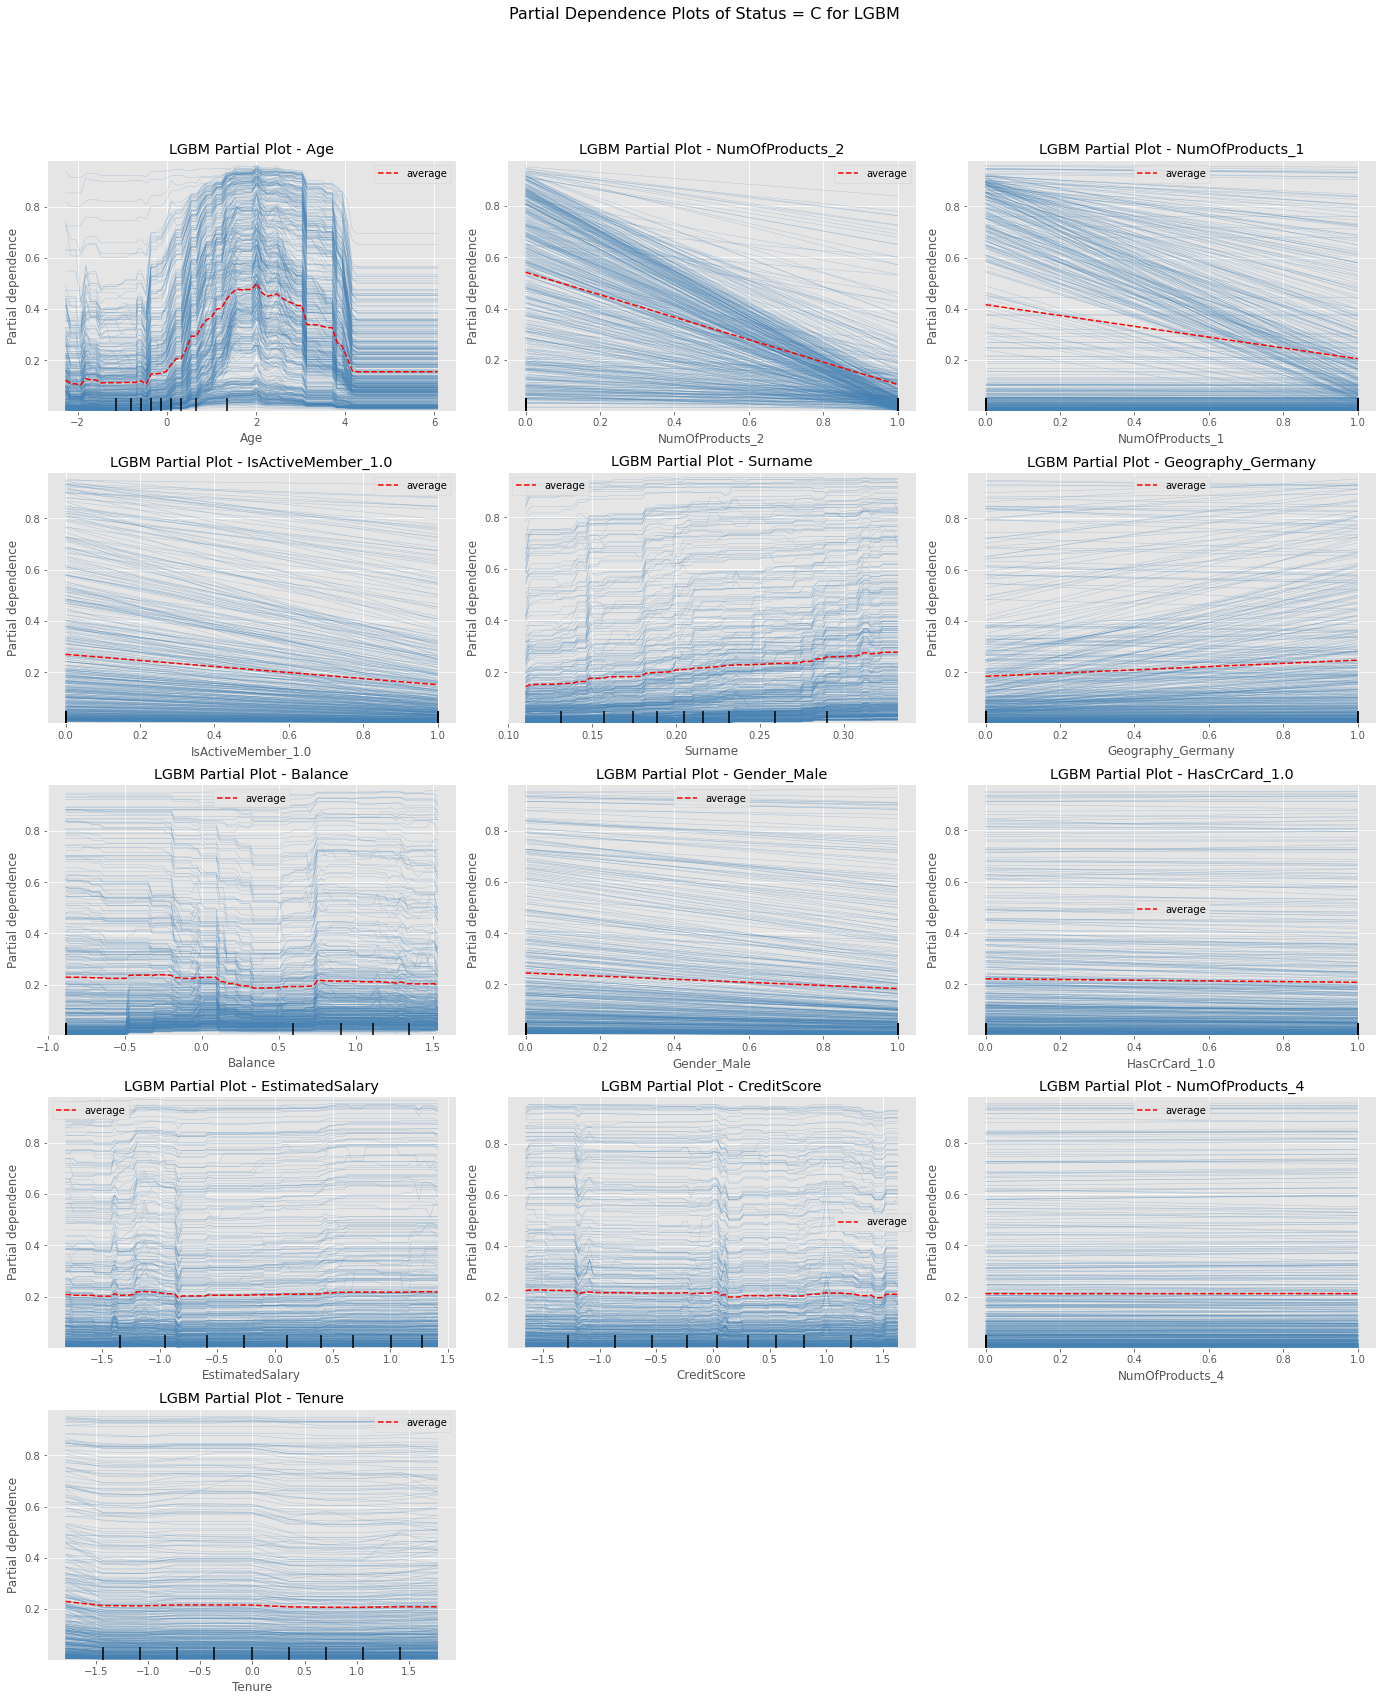

In [26]:
model = lg.fit(X[features], y)

# Number of rows for the subplot grid
num_features = len(features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create a larger figure to accommodate the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
fig.suptitle('Partial Dependence Plots of Status = C for LGBM', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=4.0, h_pad=4.0, w_pad=2.0)

# Iterate over features and create each plot
for i, feature in enumerate(features):
    ax = axs[i // num_cols, i % num_cols]
    PartialDependenceDisplay.from_estimator(model, 
                                            X[features], 
                                            [feature],
                                            pd_line_kw={'color': 'red'},
                                            ice_lines_kw={'color': 'steelblue'},
                                            kind='both',
                                            target=0,
                                            response_method='predict_proba',
                                            subsample=500,
                                            random_state=5,
                                            ax=ax)
    ax.set_title(f'LGBM Partial Plot - {feature}')

# Hide any unused subplots
for i in range(num_features, num_rows * num_cols):
    axs[i // num_cols, i % num_cols].set_visible(False)

plt.show()

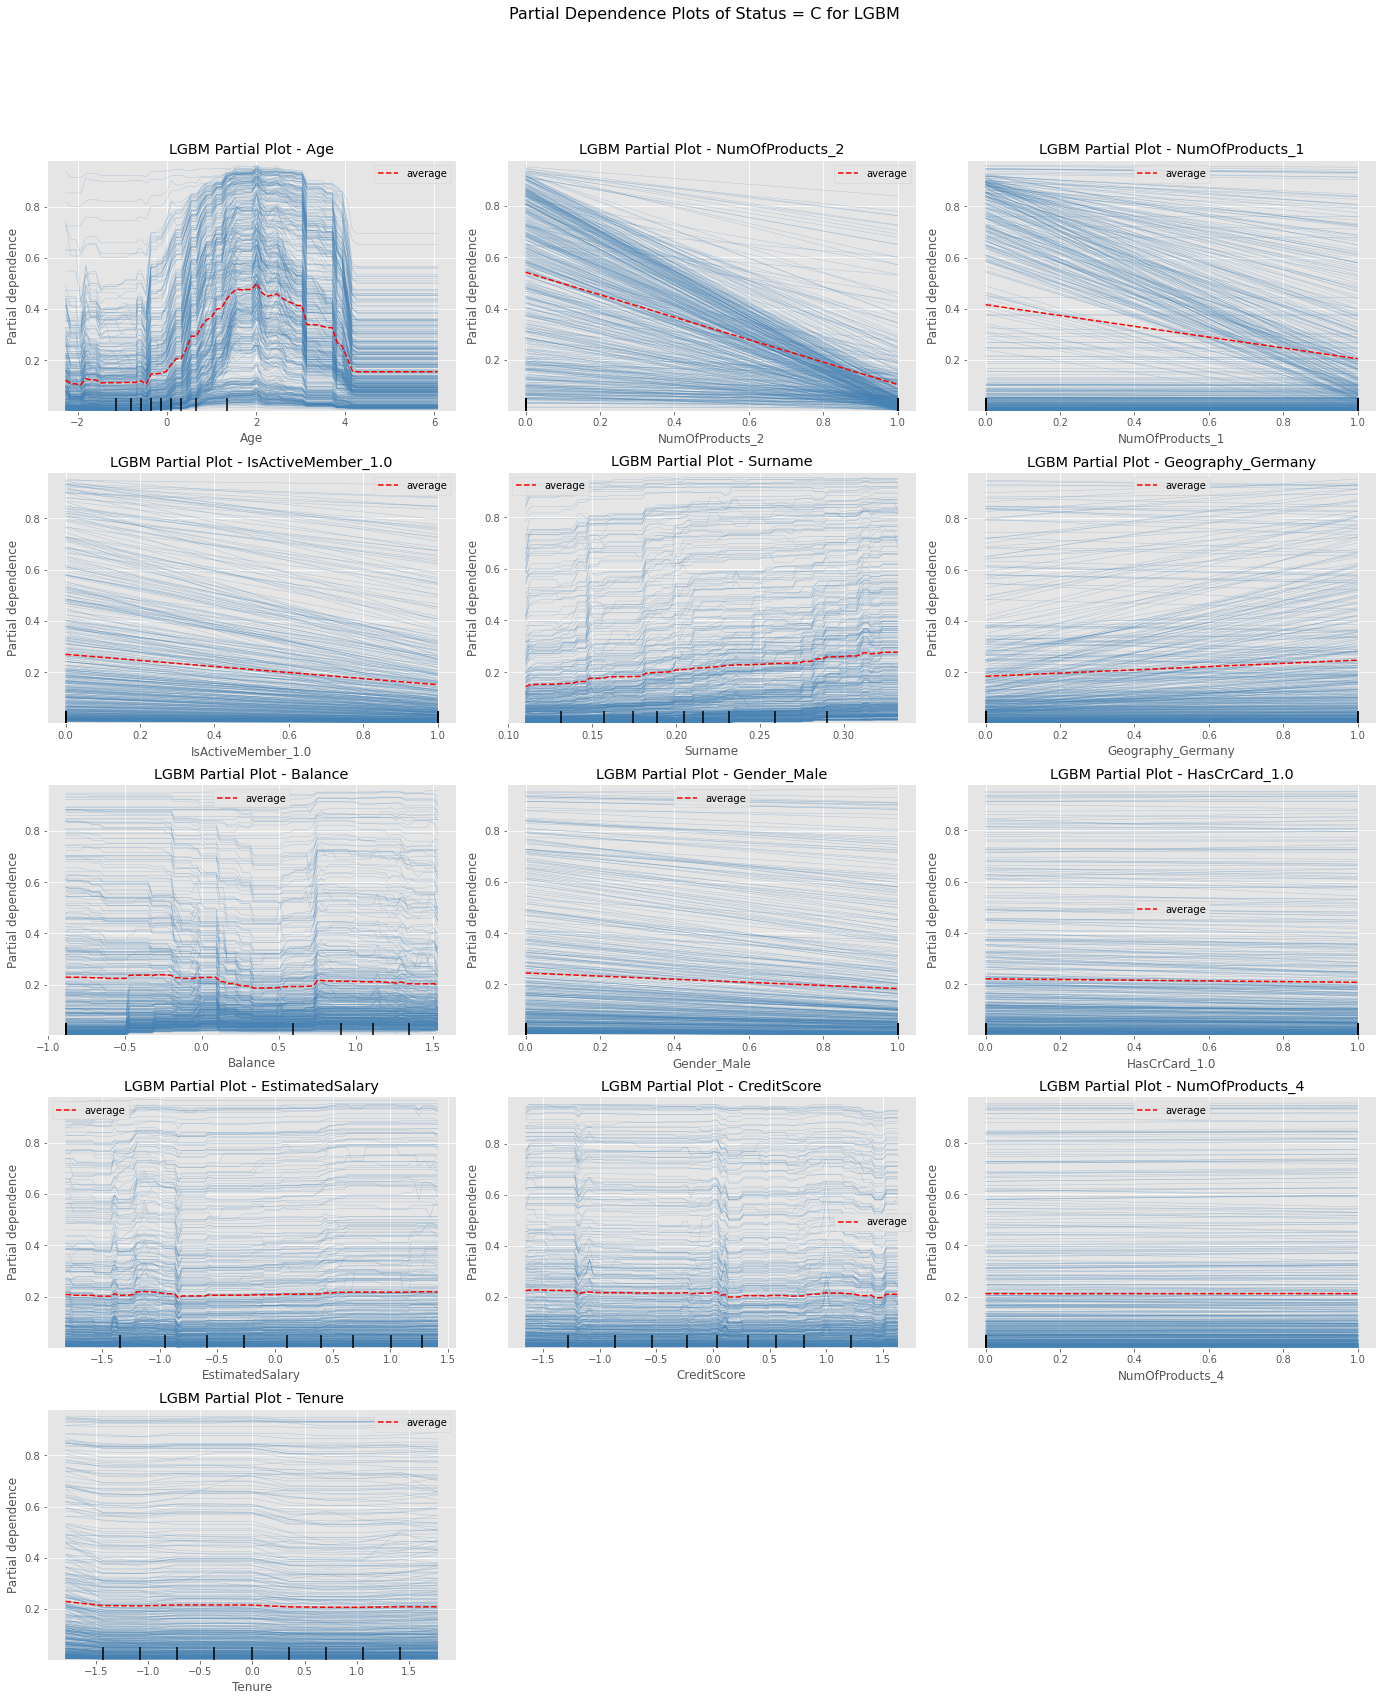

In [27]:
model = lg.fit(X[features], y)

# Number of rows for the subplot grid
num_features = len(features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create a larger figure to accommodate the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
fig.suptitle('Partial Dependence Plots of Status = C for LGBM', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=4.0, h_pad=4.0, w_pad=2.0)

# Iterate over features and create each plot
for i, feature in enumerate(features):
    ax = axs[i // num_cols, i % num_cols]
    PartialDependenceDisplay.from_estimator(model, 
                                            X[features], 
                                            [feature],
                                            pd_line_kw={'color': 'red'},
                                            ice_lines_kw={'color': 'steelblue'},
                                            kind='both',
                                            target=1,
                                            response_method='predict_proba',
                                            subsample=500,
                                            random_state=5,
                                            ax=ax)
    ax.set_title(f'LGBM Partial Plot - {feature}')

# Hide any unused subplots
for i in range(num_features, num_rows * num_cols):
    axs[i // num_cols, i % num_cols].set_visible(False)

plt.show()

In [30]:
pdp_to_drop = ['HasCrCard_1.0', 'NumOfProducts_4']

pdp_features = {'LGBMClassifier': ['Age',
                    'NumOfProducts_2',
                    'NumOfProducts_1',
                    'IsActiveMember_1.0',
                    'Surname',
                    'Geography_Germany',
                    'Balance',
                    'Gender_Male',
                    'HasCrCard_1.0',
                    'EstimatedSalary',
                    'CreditScore',
                    'NumOfProducts_4',
                    'Tenure']}

In [31]:
pdp_models = evaluate_models(models, X, y, pdp_features, sk, f'{experiment_name}_pdp')
pdp_models

Done with LGBMClassifier.


,MLA Name,MLA Parameters,MLA Train ROC AUC,MLA Test ROC AUC,MLA Time
0,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.905428,0.896991,0 min 4.88 sec
